<div><img src="autoCV_logo.png" width="220" ALIGN="left" border="20"></div>
<center><font color="4466ff"> <h1>AutoCV Challenge Tutorial </h1> </font></center>

ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS".
UNIVERSITE PARIS SUD, INRIA, CHALEARN, AND/OR OTHER ORGANIZERS
OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES.

# Before we start, you need to know that

* We target applications of multi-label image classification. 
* Raw data are provided, in TFRecord format.  
* We impose restrictions on training time and resources to push the state-of-the-art further.
* This notebook uses sample data. Download larger datasets from the website of the challenge.

In [1]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
inges_dir = 'AutoDL_ingestion_program/'           # Ingestion program directory
score_dir = 'AutoDL_scoring_program/'             # Scoring program directory
model_dir = 'AutoDL_sample_code_submission/'      # Where model code is, called model.py
baseline_dir = 'AutoDL_simple_baseline_models/'   # some baseline methods are implemented here

output_dir = 'AutoDL_scoring_output'
detailed_results_page = join(output_dir, 'detailed_results.html')

from sys import path; 
path.append(model_dir); path.append(inges_dir); path.append(score_dir); path.append(baseline_dir);

# Part 1: Dataset Overview

<font color='red'>Let's start with a sample dataset miniciao, which can be found in <code>./AutoDL_sample_data/miniciao</code>

In [3]:
data_dir = 'AutoDL_sample_data'            # Change this directory and the dataset as needed
data_name = 'miniciao'
!ls $data_dir

Monkeys  miniciao


In [4]:
# read train / test datasets
from dataset import AutoDLDataset # The module 'dataset' is defined at AutoDL_ingestion_program/dataset.py
D_train = AutoDLDataset(join(data_dir, data_name + '/' + data_name + '.data', "train"))
D_test = AutoDLDataset(join(data_dir, data_name + '/' + data_name + '.data', "test"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [5]:
# show important meta information about the dataset
print ("Dataset path: ", D_train.get_metadata().get_dataset_name())
print ("Image shape: ",  D_train.get_metadata().get_tensor_size(0))
print ("Dataset size: ", D_train.get_metadata().size())
print ("Output size: ",  D_train.get_metadata().get_output_size())
print ("Class labels: ", D_train.get_class_labels())

Dataset path:  AutoDL_sample_data/miniciao/miniciao.data/train
Image shape:  (32, 32, 3)
Dataset size:  82
Output size:  10
Class labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


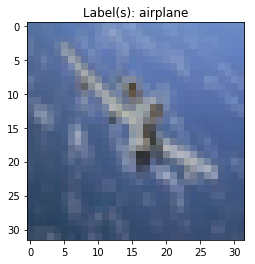

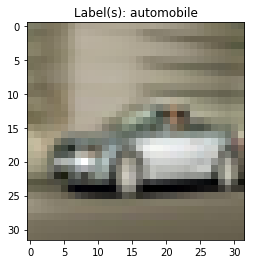

In [6]:
# show sample images
D_train.show_image(1);
D_train.show_image(11);

<font color='red'>
It should be noted that:
    
- in some datasets, the image shape is not fixed, i.e. some images are larger / smaller, when you get (-1, -1) as tensor size (image size) from meta information, it means that the image shapes are not identical in this dataset.
- not all datasets have 3 channels
- although this sample datset seems to have only one label for each image, it is not always true for other datsets.

Thus, it depends on you to choose to adapt to different datasets. 

# Part 2: Model, Prediction and Metrics

In [7]:
# copy simple model
model_simple = join(baseline_dir, 'linear', 'model.py') # choose one simple baseline model
model_submit = join(model_dir, 'model.py') # submitted models must be called model.py
!cp $model_simple $model_submit

In [8]:
# set time budget and instanciate the model with dataset
from model import Model
time_budget=200
M = Model(D_train.get_metadata())

In [9]:
# train the model for a certain time
M.train(D_train.get_dataset(), remaining_time_budget=time_budget)

2019-07-24 14:18:58,222 INFO model.py: Counting number of examples on train set.
2019-07-24 14:18:58,418 INFO model.py: Finished counting. There are 82 examples for training set.
2019-07-24 14:18:58,419 INFO model.py: Model already trained for 0.0000 epochs.
2019-07-24 14:18:58,420 INFO model.py: Begin training for another 10 steps...
2019-07-24 14:18:58,440 INFO model.py: Tensor shape before preprocessing: (1, 32, 32, 3)
2019-07-24 14:18:58,440 INFO model.py: Tensor shape after preprocessing: (1, 32, 32, 3)
2019-07-24 14:18:59,654 INFO model.py: 10 steps trained. 1.23 sec used. Now total steps trained: 10. Total time used for training + test: 0.00 sec. 


In [10]:
# get prediction by calling test method
prediction = M.test(D_test.get_dataset(), remaining_time_budget=time_budget)

2019-07-24 14:19:00,458 INFO model.py: Counting number of examples on test set.
2019-07-24 14:19:00,647 INFO model.py: Finished counting. There are 18 examples for test set.
2019-07-24 14:19:00,649 INFO model.py: Begin testing...
2019-07-24 14:19:00,663 INFO model.py: Tensor shape before preprocessing: (1, 32, 32, 3)
2019-07-24 14:19:00,663 INFO model.py: Tensor shape after preprocessing: (1, 32, 32, 3)
2019-07-24 14:19:01,062 INFO model.py: [+] Successfully made one prediction. 0.41 sec used. Duration used for test: 0.413345


<font color='red'> For each prediction made at a timestamp $t$, we compute for each (binary) class i the [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic): **$AUC_i$**, then normalize it (and average over all classes) by: 
\begin{equation*}
AUC = \frac{1}{C} \sum_{i=1}^C AUC_i, \quad NAUC = 2 \times AUC - 1,
\end{equation*}

$NAUC$ is also called Gini index in some context. Then, the learning curve can be plot as a function of **$NAUC$** vs. time. Let's denote the learning curve as $s(t)$. Since $s(t)$ is defined as the $NAUC$ of the most recent prediction made before timestamp $t$, $s(t)$ is actually a **step function**.

As this challenge aims to push forward the state-of-the-art in the **any-time learning** setting, we use a performance metric related to the whole learning curve (instead of only the last point). This metric is computed as follows.
- In order to normalize time interval [0, T] to the [0, 1] interval, we perform a time transformation by
  $$\tilde{t}(t) = \frac{\log (1 + t / t_0)}{\log( 1 + T / t_0)}$$
  where $T$ is the time budget (of default value 1200 seconds = 20 minutes) and $t_0$ is a reference time amount (of default value 60 seconds).
- Then we compute the area under learning curve using the formula
  \begin{equation*}
    \begin{aligned}
    ALC &= \int_0^1 s(t) d\tilde{t}(t) \\
    &= \int_0^T s(t) \tilde{t}'(t) dt \\
    &= \frac{1}{\log (1 + T/t_0)} \int_0^T \frac{s(t)}{ t + t_0} dt \\
    \end{aligned} 
  \end{equation*}
  we see that $s(t)$ is weighted by $1/(t + t_0)$, giving a stronger importance to predictions made at the beginning of th learning curve.

This gives the evaluation score used for one task. Later, when ALC score is computed for all tasks, the final score is obtained by the average rank (over all tasks). It should be emphasized that multi-class classification metrics are not being considered, i.e., each class is scored independently.

Let's see in the following how the scores are computed.

In [11]:
# calculate scores
from score import autodl_auc, accuracy
from libscores import read_array
solution_file = join(data_dir, data_name + '/' + data_name + '.solution')
solution = read_array(solution_file)

acc = accuracy(solution, prediction) # note that accuracy is not evaluation metric in the challenge
current_bac = autodl_auc(solution, prediction)
# print('Number of test examples: %d \n\t\t Solution \t\t\t\t\t Prediction ' % len(solution))
# [print(z) for z in zip(solution, prediction)]
print ("Classification Accuracy: ", acc)
print ("Normalized Area Under ROC Curve (NAUC) = {:.4f}.".format(current_bac))
print ("ALC can be read from the result page as shown in the next part.")

2019-07-24 14:19:05,512 WARNING score.py: Some columns in solution have only one class, ignoring these columns for evaluation.
Classification Accuracy:  0.05109918971235553
Normalized Area Under ROC Curve (NAUC) = 0.1251.
ALC can be read from the result page as shown in the next part.


# Part 3: Test and Submission

<font color='red'>
    It is important that you test your submission files before submitting them. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>AutoDL_sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 

In [12]:
# run local test
!python run_local_test.py -code_dir=./AutoDL_sample_code_submission -dataset_dir=AutoDL_sample_data/miniciao

2019-07-24 14:19:09 INFO run_local_test.py: ##################################################
2019-07-24 14:19:09 INFO run_local_test.py: Begin running local test using
2019-07-24 14:19:09 INFO run_local_test.py: code_dir = AutoDL_sample_code_submission
2019-07-24 14:19:09 INFO run_local_test.py: dataset_dir = miniciao
2019-07-24 14:19:09 INFO run_local_test.py: ##################################################
2019-07-24 14:19:09 INFO run_local_test.py: Cleaning existing output directory of last run: /app/codalab/AutoDL_sample_result_submission
2019-07-24 14:19:09 INFO run_local_test.py: Cleaning existing output directory of last run: /app/codalab/AutoDL_scoring_output
2019-07-24 14:19:09,406 INFO ingestion.py: ===== Start ingestion program. Version: v20190516 =====
2019-07-24 14:19:12,773 INFO ingestion.py: ************************************************
2019-07-24 14:19:12,773 INFO ingestion.py: ******** Processing dataset Miniciao ********
2019-07-24 14:19:12,773 INFO ingestion.

In [13]:
# result report
from IPython.core.display import display, HTML

display(HTML(detailed_results_page))

From the learning curve we see that the predictions are only made at the beginning, then the training is stopped and no more predictions are made. This is due to several reasons:
- the linear baseline by default only trains the model for 1 single epoch. This is specified by the attribute `self.num_epochs_we_want_to_train` in the class `Model`. (When this number of epochs of training is attained, the model will set `self.done_training` to `True` and ingestion program will stop the whole train/predict process and do final evaluation in scoring program);
- the dataset `miniciao` is very small as it contains only 100 examples;
- the neural network in this linear baseline method is very simple. Actually there is even no hidden layer in the neural network. 
All these factors together make the training (and testing/predicting) fast.

You are invited to change the value of `self.num_epochs_we_want_to_train` in `model.py` and/or change the arguments (typically `code_dir` and `dataset_dir`) passed to `run_local_test.py` in a cell above to test different algorithms on different datasets, and hopefully get better performance than what we had. :)

# Prepare a ZIP file ready for submission

In [14]:
# compress model to be submitted
from data_io import zipdir
submission_filename = 'mysubmission.zip'
zipdir(submission_filename, model_dir)
print("Submit this file: " + submission_filename)

Submit this file: mysubmission.zip


# Next steps

<font color='red'>
If you run the above cells successfully, congratulations! You are all set! In order to get better score on the challenge, you need to design your model carefully, that can learn better and faster on different datasets.

<font color='red'>
You don't need to write from scratch, but can instead follow our provided baseline model. Basically, you need to write three functions: (these functions can be found in <code>model.py</code>)

- <code>preprocess_tensor_4d</code> (optional) for preprocessing data, e.g. resize, change gray images to RGB images
- <code>input_function</code> (optional) for reading batchs
- <code>model_fn</code> (mandatory) for defining your own models, CNN, ResNet, Inception, etc.

For instructions on wrinting <code>model_fn</code>, you are invited to consult this page for reference: 
https://www.tensorflow.org/guide/custom_estimators#write_a_model_function

Good luck!